In [1]:
import fastbook

fastbook.setup_book()

In [2]:
import torch

gpu = torch.device("mps")
cpu = torch.device("cpu")
device = gpu

## Gather MNIST data

### Download dataset

In [3]:
from pathlib import Path

from fastai.data.external import URLs, untar_data

path = untar_data(URLs.MNIST)
print(f"MNIST data downloaded to {path}")
# Path.BASE_PATH = path

MNIST data downloaded to /Users/david/.fastai/data/mnist_png


### Define how to access images from training and testing datasets

In [4]:
from enum import Enum
from typing import List, Literal

Digit = Literal[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


class DataSplit(Enum):
    TRAINING = "training"
    TESTING = "testing"


def get_digit_file_paths(digit: Digit, datasplit: DataSplit) -> List[Path]:
    return list((path / datasplit.value / str(digit)).ls().sorted())


#### Peek into the images before turning them into tensors

In [5]:
from PIL import Image

im4 = Image.open(get_digit_file_paths(4, DataSplit.TRAINING)[0])
print(f"Image shape is {im4.shape}")
im4

Image shape is (28, 28)


#### Images as tensors

In [6]:
from functools import cache

from fastai.torch_core import tensor


@cache
def get_digit_tensors(digit: Digit, datasplit: DataSplit) -> List[tensor]:
    """Gets all tensor images for the given digit in the specified DataSet."""
    return [tensor(Image.open(path), device=device) for path in get_digit_file_paths(digit, datasplit)]


<Axes: >

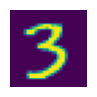

In [7]:
from fastai.torch_core import show_image

show_image(get_digit_tensors(3, DataSplit.TRAINING)[1])

## Utilities

### Ensuring tensor shape

In [8]:
from typing import Final, Tuple

from torch import Tensor

IMAGE_SHAPE: Final[Tuple[int, int]] = (28, 28)


class EmptyInputError(Exception):
    pass


class TensorShapeError(Exception):
    def __init__(self, message: str, offending_tensor: Tensor):
        self.offending_tensor = offending_tensor
        super().__init__(message)


def ensure_shape(tensor: Tensor, expected: Tuple[int, ...]) -> tensor:
    """Validates tensor shape matches expected dimensions. Use -1 for 'any'."""
    if len(tensor.shape) != len(expected):
        raise TensorShapeError(
            "Tensor shape and expected shape must have the "
            "same number of dimensions. "
            f"Got {len(tensor.shape)} and {len(expected)}.",
            tensor,
        )
    for actual, expected in zip(tensor.shape, expected):
        if expected == -1:
            continue
        if actual != expected:
            raise TensorShapeError(
                f"Expected shape {expected}, got {tensor.shape}", tensor
            )
    return tensor


### Adjusting pixel values to 0...1 floats

In [9]:
def normalize_pixel_data(input: Tensor) -> Tensor:
    """Probably not a good name. Takes a tensor of image data with pixel values
    between 0 and 255 and returns a tensor with float values between 0 and 1"""
    return input.float() / 255

### Stacking tensor images

In [10]:
from typing import Sequence


def stack_image_tensors(image_tensors: Sequence[tensor]) -> Tensor:
    """Takes a sequence of MNIST digit image tensors and returns a single tensor
    whose first dimension refers to each of the images."""

    if len(image_tensors) == 0:
        raise EmptyInputError(
            "The input sequence of tensors must have at least one element."
        )

    for t in image_tensors:
        ensure_shape(t, IMAGE_SHAPE)

    # It may be silly to wrap this in a function, but doing so adds some semantics
    # and checks that the input has the expected shape.
    stacked = torch.stack(image_tensors)

    # This should never raise, so it just documents what I'm expecting.
    ensure_shape(stacked, (-1,) + IMAGE_SHAPE)
    return stacked

@cache
def get_stacked_preprocessed_digits(digit: Digit, datasplit: DataSplit) -> Tensor:
    """Gets all images for a given digit in the specified datasplit, stacked in a
    single tensor and normalized."""
    print(f"get_stacked_preprocessed_digits is running for digit: {digit}, split: {datasplit}")
    return normalize_pixel_data(stack_image_tensors(get_digit_tensors(digit, datasplit)))

In [11]:
#| test
def test_stacked_threes():
    stacked_training_threes = stack_image_tensors(get_digit_tensors(3, DataSplit.TRAINING))
    # A stacked tensor of threes is rank-3 with ~6k images, each of which is 28 x 28 pixels.
    assert(stacked_training_threes.shape == (6131,) + IMAGE_SHAPE)

<Axes: >

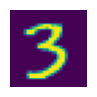

In [12]:
test_stacked_threes()
show_image(stack_image_tensors(get_digit_tensors(3, DataSplit.TRAINING))[1])

## Baseline: Pixel Similarity

### Calculating the mean digit images

In [13]:
def mean_image(stacked_images: Tensor) -> Tensor:
    """Calculates the "ideal" digit image, composed of the mean pixel values from
    each of the images in the first (0) dimension in the `stacked_images` argument."""
    ensure_shape(stacked_images, (-1,) + IMAGE_SHAPE)
    mean = torch.mean(
        stacked_images, 0, dtype=torch.float32
    )  # why can't pytorch infer the dtype?
    ensure_shape(mean, IMAGE_SHAPE)
    return mean


@cache
def mean_digit_image(digit: Digit, datasplit: DataSplit) -> Tensor:
    """Gets an averaged image for a given digit in a specified DataSet."""
    return mean_image(get_stacked_preprocessed_digits(digit, datasplit))


def mean_digit_images(datasplit: DataSplit) -> Tensor:
    """Returns the averaged image for each digit for the specified DataSet."""
    return torch.stack([mean_digit_image(digit, datasplit) for digit in range(0, 10)])


get_stacked_preprocessed_digits is running for digit: 0, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 1, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 2, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 3, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 4, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 5, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 6, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 7, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 8, split: DataSplit.TRAINING
get_stacked_preprocessed_digits is running for digit: 9, split: DataSplit.TRAINING


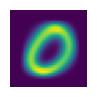

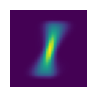

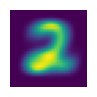

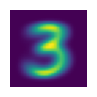

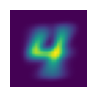

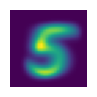

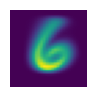

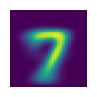

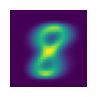

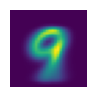

In [14]:
for digit in range(0, 10):
    show_image(mean_digit_images(DataSplit.TRAINING)[digit])


### Calculating how close a given digit image is from the "ideal", or mean image for that digit

* Mean absolute difference, or L1 norm, is the mean of the absolute value of the differences between pixels.
* Root mean square error, RMSE, or L2 norm, takes the mean of the squares of the differences and then the square root of that mean.
  * this one penalizes larger mistakes more and smaller mistakes less

In [15]:
def l1_norm(candidate: Tensor, ideal: Tensor) -> Tensor:
    """Calculates the mean of the absolute value of the differences between
    pixels of the candidate and the "ideal" image tensors.
    Returns a scalar wrapped in a rank-0 tensor."""
    ensure_shape(candidate, IMAGE_SHAPE)
    ensure_shape(ideal, IMAGE_SHAPE)
    result = (candidate - ideal).abs().mean()
    ensure_shape(result, ())
    return result


def l2_norm(candidate: Tensor, ideal: Tensor) -> Tensor:
    """Calculates the root of the mean of the squares of the differences
    (that is diff_tensor -> square -> mean_scalar -> sqrt)
    between pixels of the candidate and the "ideal" image tensors.
    Returns a scalar wrapped in a rank-0 tensor."""
    ensure_shape(candidate, IMAGE_SHAPE)
    ensure_shape(ideal, IMAGE_SHAPE)
    result = ((candidate - ideal) ** 2).mean().sqrt()
    ensure_shape(result, ())
    return result

In [16]:
[
    norm_function(
        get_stacked_preprocessed_digits(3, DataSplit.TRAINING)[0],
        mean_digit_image(3, DataSplit.TRAINING),
    )
    for norm_function in [l1_norm, l2_norm]
]

[tensor(0.1074, device='mps:0'), tensor(0.1912, device='mps:0')]

In [17]:
# TODO: Consider removing check_shape
def mnist_distance(
    candidate_s: Tensor, ideal: Tensor, check_shape: bool = True
) -> Tensor:
    """Calculates the "distance(s)" between a candidate image tensor OR a tensor of
    candidate image tensors and an "ideal" image tensor.
    If passed a single candidate it will return a scalar wrapped in a rank-0 tensor,
    and if passed a tensor of candidates it will return a rank-1 tensor with the
    corresponding distances (by broadcasting the "ideal" tensor.)
    The "distance(s)" is/are calculated by taking the absolute difference of the pixel
    values of candidate-ideal image pairs and calculating the mean of those pixel
    differences, resulting in a scalar for each of the candidates."""
    if check_shape:
        if candidate_s.ndim == 2:  # single image
            ensure_shape(candidate_s, IMAGE_SHAPE)
        else:  # many images
            ensure_shape(candidate_s, (-1,) + IMAGE_SHAPE)

    distance_s = (candidate_s - ideal).abs().mean((-1, -2))
    # "The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the
    # last element, and -2 refers to the second-to-last. So in this case, this
    # tells PyTorch that we want to take the mean ranging over the values indexed
    # by the last two axes of the tensor. The last two axes are the horizontal
    # and vertical dimensions of an image."

    if check_shape:
        if candidate_s.ndim == 2:
            # The output is a rank-0 tensor wrapping a single distance value for
            # one image.
            ensure_shape(distance_s, ())
        else:
            # The output vector has as many distance values as there are images in
            # the input tensor.
            ensure_shape(distance_s, (candidate_s.shape[0],))
    return distance_s


#### Distance between a three and the ideal three

In [18]:
_distance = mnist_distance(
    get_stacked_preprocessed_digits(3, DataSplit.TRAINING)[0],
    mean_digit_image(3, DataSplit.TRAINING),
)
print(f"shape: {_distance.shape}")
_distance

shape: torch.Size([])


tensor(0.1074, device='mps:0')

#### Distances between each of the threes and the ideal three

In [19]:
_distances = mnist_distance(
    get_stacked_preprocessed_digits(3, DataSplit.TRAINING),
    mean_digit_image(3, DataSplit.TRAINING),
)
print(f"shape: {_distances.shape}")
_distances

shape: torch.Size([6131])


tensor([0.1074, 0.1114, 0.1100,  ..., 0.1316, 0.1220, 0.1267], device='mps:0')

#### Distance between a concrete three and each of the ideal digits

In [20]:
_distances = mnist_distance(
    get_stacked_preprocessed_digits(3, DataSplit.TRAINING)[0],
    mean_digit_images(DataSplit.TRAINING),
    check_shape=False
)
print(f"shape: {_distances.shape}")
_distances

shape: torch.Size([10])


tensor([0.1750, 0.1153, 0.1501, 0.1074, 0.1635, 0.1326, 0.1579, 0.1441, 0.1345, 0.1402], device='mps:0')

#### Distance between each of the threes and each of the ideal digits

In [21]:
# I'm going to use this later so I'll wrap it in a function
def calculate_distances(
    digit: Digit, from_datasplit: DataSplit, to_ideal_digits_datasplit: DataSplit
) -> Tensor:
    expected_digit_count = len(get_digit_file_paths(digit, from_datasplit))
    shaped_concrete_digits = get_stacked_preprocessed_digits(
        digit, from_datasplit
    ).unsqueeze(1)
    ensure_shape(
        shaped_concrete_digits, (expected_digit_count, 1) + IMAGE_SHAPE
    )  # [~6K, 1, 28, 28]
    shaped_means = mean_digit_images(DataSplit.TRAINING).unsqueeze(0)
    ensure_shape(shaped_means, (1, 10, 28, 28))
    distances = mnist_distance(shaped_concrete_digits, shaped_means, check_shape=False)
    ensure_shape(distances, (expected_digit_count, 10))  # [~6K, 10]
    return distances

In [22]:
_distances = calculate_distances(
    digit=3,
    from_datasplit=DataSplit.TRAINING,
    to_ideal_digits_datasplit=DataSplit.TRAINING,
)
print(f"shape: {_distances.shape}")
_distances

shape: torch.Size([6131, 10])


tensor([[0.1750, 0.1153, 0.1501,  ..., 0.1441, 0.1345, 0.1402],
        [0.1879, 0.1353, 0.1734,  ..., 0.1586, 0.1550, 0.1601],
        [0.1644, 0.1433, 0.1583,  ..., 0.1541, 0.1343, 0.1580],
        ...,
        [0.1793, 0.1582, 0.1610,  ..., 0.1792, 0.1474, 0.1682],
        [0.1531, 0.1253, 0.1451,  ..., 0.1548, 0.1519, 0.1636],
        [0.1655, 0.1257, 0.1459,  ..., 0.1509, 0.1496, 0.1622]], device='mps:0')

#### Distance between each concrete digit and each of the ideal digits

In [23]:
# Will use a loop instead of broadcasting because the training sets of different
# digits have different lengths. Alternatively I could cap all of them to the
# same length.
[
    calculate_distances(
        digit,
        from_datasplit=DataSplit.TRAINING,
        to_ideal_digits_datasplit=DataSplit.TRAINING
    )
    for digit in range(0, 10)
]

[tensor([[0.1108, 0.1643, 0.1788,  ..., 0.1690, 0.1708, 0.1694],
         [0.1388, 0.1526, 0.1672,  ..., 0.1497, 0.1403, 0.1419],
         [0.1648, 0.2191, 0.2223,  ..., 0.2229, 0.1988, 0.2094],
         ...,
         [0.1840, 0.2321, 0.2240,  ..., 0.1964, 0.2131, 0.1986],
         [0.1632, 0.1615, 0.1785,  ..., 0.1630, 0.1811, 0.1789],
         [0.1759, 0.1757, 0.1972,  ..., 0.1652, 0.1886, 0.1731]], device='mps:0'),
 tensor([[0.1806, 0.0530, 0.1449,  ..., 0.1242, 0.1341, 0.1291],
         [0.1887, 0.0601, 0.1335,  ..., 0.1253, 0.1335, 0.1288],
         [0.1778, 0.0636, 0.1443,  ..., 0.1152, 0.1388, 0.1200],
         ...,
         [0.1927, 0.0658, 0.1367,  ..., 0.1443, 0.1331, 0.1428],
         [0.1961, 0.0737, 0.1385,  ..., 0.1479, 0.1319, 0.1455],
         [0.1890, 0.0519, 0.1433,  ..., 0.1300, 0.1319, 0.1326]], device='mps:0'),
 tensor([[0.1959, 0.1587, 0.1350,  ..., 0.1854, 0.1608, 0.1797],
         [0.1822, 0.1275, 0.1243,  ..., 0.1417, 0.1509, 0.1457],
         [0.1836, 0.1078, 

In [24]:
# given a concrete digit, which ideal digit is it closer to?
def match(image: Tensor, ideals: Tensor) -> Digit:
    ensure_shape(image, IMAGE_SHAPE)
    ensure_shape(ideals, (10,) + IMAGE_SHAPE)
    distances = mnist_distance(image, ideals, check_shape=False)
    ensure_shape(distances, (10,))
    # if there's more than one min this will produce the index of the first one
    min_indexes = torch.argmin(distances)
    min_index = min_indexes.item()
    assert min_index in range(0, 10)
    return min_index


In [25]:
match(
    image=get_stacked_preprocessed_digits(8, DataSplit.TRAINING)[3],
    ideals=mean_digit_images(DataSplit.TRAINING),
)

1

In [26]:
# given a tensor of stacked digit images, which ideal digit is each closer to?
def matches_for_images(images, ideals: Tensor) -> Tensor:
    ensure_shape(images, (-1,) + IMAGE_SHAPE)
    image_count = images.shape[0]
    shaped_images = images.unsqueeze(1)
    ensure_shape(shaped_images, (image_count, 1) + IMAGE_SHAPE)
    ensure_shape(ideals, (10,) + IMAGE_SHAPE)
    shaped_ideals = ideals.unsqueeze(0)
    ensure_shape(shaped_ideals, (1, 10) + IMAGE_SHAPE)
    distances = mnist_distance(shaped_images, shaped_ideals, check_shape=False)
    ensure_shape(distances, (image_count, 10))
    digits = torch.argmin(distances, dim=1)
    ensure_shape(digits, (image_count,))
    return digits


def matches_for_digit(
    digit: Digit,
    from_datasplit: DataSplit,
    ideals_datasplit: DataSplit,
) -> Tensor:
    return matches_for_images(
        images=get_stacked_preprocessed_digits(digit, from_datasplit),
        ideals=mean_digit_images(ideals_datasplit),
    )

matches_for_digit(
    3,
    from_datasplit=DataSet.TRAINING,
    ideals_datasplit=DataSet.TRAINING,
)

In [27]:
_matches_3s = matches_for_images(
    images=get_stacked_preprocessed_digits(3, DataSplit.TRAINING),
    ideals=mean_digit_images(DataSplit.TRAINING),
)
_correct_3s = _matches_3s == 3
_correct_3s

tensor([ True,  True,  True,  ...,  True,  True, False], device='mps:0')

In [28]:
_correct_3s.float().mean()

tensor(0.5836, device='mps:0')

In [29]:
[matches_for_digit(digit, DataSplit.TRAINING, DataSplit.TRAINING) for digit in range(0, 10)]

[tensor([0, 5, 0,  ..., 0, 1, 7], device='mps:0'),
 tensor([1, 1, 1,  ..., 1, 1, 1], device='mps:0'),
 tensor([2, 2, 1,  ..., 1, 9, 2], device='mps:0'),
 tensor([3, 3, 3,  ..., 3, 3, 1], device='mps:0'),
 tensor([4, 9, 4,  ..., 4, 4, 4], device='mps:0'),
 tensor([5, 1, 5,  ..., 1, 5, 1], device='mps:0'),
 tensor([6, 1, 1,  ..., 6, 1, 1], device='mps:0'),
 tensor([7, 7, 7,  ..., 7, 7, 7], device='mps:0'),
 tensor([1, 3, 1,  ..., 1, 1, 1], device='mps:0'),
 tensor([9, 9, 9,  ..., 9, 7, 9], device='mps:0')]

In [30]:
def baseline_accuracy(
    digit: Digit,
    from_datasplit: DataSplit,
    ideals_datasplit: DataSplit,
) -> Tensor:
    matches = matches_for_digit(digit, from_datasplit, ideals_datasplit)
    corrects = matches == digit
    accuracy = corrects.float().mean()
    ensure_shape(accuracy, ())  # returns a rank-0 tensor
    return accuracy


def baseline_accuracies(
    from_datasplit: DataSplit,
    ideals_datasplit: DataSplit,
) -> List[float]:
    # digits have different counts of samples
    # so this is iterated instead of broadcasted
    return [
        baseline_accuracy(digit, from_datasplit, ideals_datasplit).item()
        for digit in range(0, 10)
    ]

In [31]:
for (i, calculate_accuracy_plain_labels) in enumerate(baseline_accuracies(DataSplit.TRAINING, DataSplit.TRAINING)):
    print(f"{i}: {calculate_accuracy_plain_labels:.3f}")

0: 0.814
1: 0.998
2: 0.433
3: 0.584
4: 0.665
5: 0.300
6: 0.745
7: 0.778
8: 0.396
9: 0.716


## As a linear model

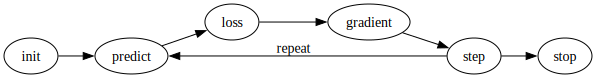

In [32]:
from fastbook import gv

gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [33]:
from functools import reduce


def labeled_data(datasplit: DataSplit) -> Tuple[Tensor, Tensor]:
    _all_digits = range(0, 10)
    _stacked_digits = [
        get_stacked_preprocessed_digits(digit, datasplit) for digit in _all_digits
    ]
    _lengths = [len(get_digit_file_paths(digit, datasplit)) for digit in _all_digits]

    train_x = torch.cat(_stacked_digits).view(-1, IMAGE_SHAPE[0] * IMAGE_SHAPE[1])
    train_y = tensor(
        reduce(lambda a, b: a + b, [[digit] * _lengths[digit] for digit in _all_digits]),
        dtype=torch.int64,
        device=device,
    )
    return (train_x, train_y)

train_x, train_y = labeled_data(DataSplit.TRAINING)
valid_x, valid_y = labeled_data(DataSplit.TESTING)
print(f"Training: {train_x.shape, train_y.shape}")
print(f"Validation - testing: {valid_x.shape, valid_y.shape}")

get_stacked_preprocessed_digits is running for digit: 0, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 1, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 2, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 3, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 4, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 5, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 6, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 7, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 8, split: DataSplit.TESTING
get_stacked_preprocessed_digits is running for digit: 9, split: DataSplit.TESTING
Training: (torch.Size([60000, 784]), torch.Size([60000]))
Validation - testing: (torch.Size([10000, 784]), torch.Size([10000]))


A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. 
It looks like this: $[(x_1,y_1), (x_2,y_2), ... (x_n,y_n)]$

In [34]:
training_dset = list(zip(train_x, train_y))

In [35]:
batch_x,batch_y = training_dset[0]
batch_x.shape, batch_y.shape

(torch.Size([784]), torch.Size([]))

### Functions to initialize parameters

In [36]:
from typing import Union

from torch import SymInt


def init_params(shape: Union[int, SymInt], std: float = 1.0) -> Tensor:
    return (torch.randn(shape, device=device) * std).requires_grad_()

# TODO: I could add a different kind of param initializer here such as Kaiming

In the book the model has to differentiate between 2 digits, so the model has a single output. 0.0 is used as some kind of threshold: any values greater than 0 represent a prediction for one digit, the others represent the other digit. For this 2-digit model, `train_y` is a vector of 1s for one digit and 0s for the other digit. (And then unsqueezed to a second dimension of size 1).

0 is at the center of the model outputs distribution, then they switch it to 0.5 (that is, all values between 0 and 1) using **sigmoid**.

I want to switch the model from having one input $y_1$ (probability of input being digit a, and $y_2=1-y_1$) to 10 outputs (originally I was thinking 9 so I would calculate the 10th as $1-p(others)$, but it makes more sense to use Softmax for 10 outputs, as the probs of the 10 should add to 1).

In [37]:
count_outputs = 10

In [38]:
weights = init_params((IMAGE_SHAPE[0] * IMAGE_SHAPE[1], count_outputs))
biases = init_params(count_outputs)

In [39]:
print(f"Shape of the full training data: {train_x.shape}")
print(f"Shape of the weights: {weights.shape}")

Shape of the full training data: torch.Size([60000, 784])
Shape of the weights: torch.Size([784, 10])


### Run the model "manually"

So I better understand the forward computation.

How I think the `batch @ weights + bias`, equation operates in a linear model with several outputs: it has 9 sets of parameters and 9 biases. So I'm imagining it's just that equation once per output probability, with the same input data, independently and in parallel.

#### Run it once for a single image

In [40]:
first_image = train_x[0]
print(f"Shape of the first image: {first_image.shape}")

# the T is transpose, flipping weights from [784, count_outputs] to [count_outputs, 784]
transposed_weights = weights.T
print(f"Shape of transposed weights: {transposed_weights.shape}")

element_wise_product = first_image * transposed_weights
print(f"Shape of element-wise multiplication: {element_wise_product.shape}")

model_result = element_wise_product.sum() + biases
print(f"Shape of model result: {model_result.shape}")
print(f"Model result: {model_result}")

Shape of the first image: torch.Size([784])
Shape of transposed weights: torch.Size([10, 784])
Shape of element-wise multiplication: torch.Size([10, 784])
Shape of model result: torch.Size([10])
Model result: tensor([5.0383, 6.0956, 6.5828, 5.7916, 7.5112, 6.7692, 5.8542, 6.7100, 6.4550, 6.5091], device='mps:0', grad_fn=<AddBackward0>)


#### Run it once for a batch data using broadcasting (no loops!)

In [41]:
batch = train_x  # the whole dataset -- it still feels instantaneous

print(f"Shape of batch: {batch.shape}")
print(f"Shape of weights: {weights.shape}")
print(f"Shape of bias: {biases.shape}")


# Here is one of the two magic equations (the other one is the activation
# function), equivalent to doing the run above but for each image in the batch
# (in this case the full training set).
model_result = batch @ weights + biases

print(f"Shape of results: {model_result.shape}")

Shape of batch: torch.Size([60000, 784])
Shape of weights: torch.Size([784, 10])
Shape of bias: torch.Size([10])
Shape of results: torch.Size([60000, 10])


### Model wrapped in a class

In [42]:
# Wrapped in a class, together with its weights and biases, like models
# in the pytorch nn package:

from abc import ABC, abstractmethod
from typing import Callable


class Model(ABC):
    @abstractmethod
    def run(self, batch: Tensor) -> Tensor:
        pass


class LinearModel(Model):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        init_params_function: Callable[
            [Union[int, SymInt]], Tensor
        ],  # takes shape, returns tensor
    ):
        self.weights = init_params_function((in_features, out_features))
        self.biases = init_params_function(out_features)

    def run(self, batch: Tensor) -> Tensor:
        # Apply linear transformation: batch @ weights + biases
        linear = batch @ self.weights + self.biases
        return linear  # return unnormalized logits


This is a linear model to test some functions below:

In [43]:
_linear_model = LinearModel(
    in_features=IMAGE_SHAPE[0] * IMAGE_SHAPE[1],
    out_features=count_outputs,
    init_params_function=init_params,
)

### Normalizers of logits to predictions

In [44]:
def normalize_softmax(logits: Tensor) -> Tensor:
    """Normalizes logits applying softmax.

    Returns:
        Tensor: A tensor of predictions with the same dimensions as the input.
        Predictions sum 1, and equal to the probability of each class match.
    """
    return torch.softmax(logits, dim=1)

def normalize_log_softmax(logits: Tensor) -> Tensor:
    """Normalizes logits applying log softmax.

    Returns:
        Tensor: A tensor of predictions with the same dimensions as the input.
        Predictions sum 1, and equal to the probability of each class match.
    """
    return torch.log_softmax(logits, dim=1)


### Functions to turn labels into targets

In [45]:
import torch.nn.functional as F


def encode_one_hot_targets(labels: Tensor, num_classes = 10) -> Tensor:
    return F.one_hot(labels, num_classes).float()

def pass_through_labels(labels: Tensor) -> Tensor:
    return labels

In [46]:
print(valid_y[0])
print(encode_one_hot_targets(valid_y)[0])


tensor(0, device='mps:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0')


### Functions to validate the model

In [47]:
def calculate_accuracy_plain_labels(preds: Tensor, labels: Tensor) -> float:
    """Calculates the accuracy of a matrix of predictions given a vector of labels.

    Args:
        preds (Tensor): A 2D matrix of image index to digit match likelihoods.
        These can be logits or normalized. Just the maximum value of each row is used.
        labels (Tensor): A 1D vector of labels corresponding to each image

    Returns:
        float: A scalar indicating the average accuracy
    """
    assert preds.ndim == 2
    ensure_shape(labels, (preds.shape[0],))
    preds_as_digits = preds.argmax(dim=1)
    correct = preds_as_digits == labels
    return correct.float().mean().item()

def validate_model_plain_labels(model: Model, valid_x: Tensor, valid_y: Tensor) -> float:
    return calculate_accuracy_plain_labels(model.run(valid_x), valid_y)

In [48]:
calculate_accuracy_plain_labels(_linear_model.run(valid_x), valid_y)

0.09120000153779984

### Functions to calculate the loss

Even though the normalization step (such as Softmax) seems to conceptually fit better with the model, I see it being used in the loss function. I've extracted it into a normalizer.

In [49]:
def calculate_loss_plain_labels(preds: Tensor, labels: Tensor) -> Tensor:
    # preds must be normalized
    ensure_shape(labels, (preds.shape[0],))
    probs_right_guesses = torch.gather(
        preds,
        dim=1,
        index=labels.unsqueeze(
            dim=1
        ),  # unsqueeze because "Index tensor must have the same number of dimensions as input tensor"
    )
    losses = 1 - probs_right_guesses
    return ensure_shape(losses.sum(), ())


def calculate_loss_one_host_targets(preds: Tensor, targets: Tensor) -> Tensor:
    # preds must be normalized
    assert preds.shape == targets.shape

    # TODO is there a more efficient way to do this?
    probability_right_guesses = torch.where(
        targets == 1.0, preds, torch.zeros_like(preds)
    )
    losses = 1 - probability_right_guesses.sum(dim=1)
    return losses.sum()

These two actually return the same value currently:

In [50]:
calculate_loss_plain_labels(normalize_softmax(_linear_model.run(train_x)), train_y)

tensor(55067.4375, device='mps:0', grad_fn=<SumBackward0>)

In [51]:
calculate_loss_one_host_targets(
    normalize_softmax(_linear_model.run(train_x)),
    encode_one_hot_targets(train_y),
)

tensor(55067.4375, device='mps:0', grad_fn=<SumBackward0>)

### Datasets and DataLoaders

A collection that contains tuples of independent and dependent variables is a dataset

In [52]:
train_dataset = list(zip(train_x, train_y))
valid_dataset = list(zip(valid_x, valid_y))

Take a look somewhere in a dataset:

tensor(6, device='mps:0')

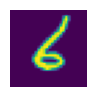

In [53]:
_index = 40000
show_image(train_dataset[_index][0].view((IMAGE_SHAPE)))
train_dataset[_index][1]

When we pass a dataset to a DataLoader we will get back many batches that are themselves tuples of tensors representing batches of independent and dependent variables.

In [54]:
from fastai.data.load import DataLoader

# A dataloader with a tiny batch size for playing around
train_dl = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [55]:
from fastai.basics import first

first_training_batch = first(train_dl)

Each training batch is a tuple of two tensors.

In [56]:
assert isinstance(first_training_batch, tuple), "first_training_batch should be a tuple"
assert len(first_training_batch) == 2, "first_training_batch should have length 2"

The first element is a tensor of images and the second is a tensor of labels. Both have the same length, which corresponds to the `batch_size` passed to the `DataLoader` constructor above.

In [57]:
_images, _labels = first_training_batch

In [58]:
_images.shape

torch.Size([2, 784])

In [59]:
_labels.shape

torch.Size([2])

The first image and label in the batch:

Take a look into the first dataloader batch -> first image and label:

tensor(2, device='mps:0')

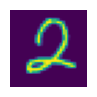

In [60]:
show_image(first(_images).view(IMAGE_SHAPE))
first(_labels)

### Training

#### Forward pass + calc grads

In [61]:
# Returns average loss
def forward_pass_calc_grad(
    batch_x: Tensor,
    batch_y: Tensor,
    model: Model,
    normalize: Callable[[Tensor], Tensor],
    loss_function: Callable[[Tensor, Tensor], Tensor],
) -> float:
    logits = model.run(batch_x)
    preds = normalize(logits)
    loss = loss_function(preds, batch_y)
    loss.backward()
    return loss.item()

#### Optimizer

In [62]:
class Optimizer:
    def __init__(self, learning_rate: float, weights: Tensor, biases: Tensor):
        self.learning_rate = learning_rate
        self.weights = weights
        self.biases = biases

    def step(self):
        # for p in self.params: p.data -= p.grad.data * self.lr
        self.weights.data -= self.weights.grad.data * self.learning_rate
        self.biases.data -= self.biases.grad.data * self.learning_rate

    def zero_grad(self):
        # for p in self.params: p.grad = None
        self.weights.grad.zero_()
        self.biases.grad.zero_()


#### Cycle of training

In [135]:
import matplotlib.pyplot as plt

# train_dl = DataLoader(train_dataset, batch_size=8192, shuffle=True, device=device)

# TODO: untied end: training data with labels or targets


from typing import Generator


def train_model(
    x,
    y,
    model,
    *,
    normalizer,
    loss_function,
    optimizer,
    epochs: int,
) -> Generator[Tuple[int, float], None, None]:
    for epoch in range(epochs):
        #    for batch_x, batch_y in train_dl:
        forward_pass_calc_grad(
            x,
            y,
            model,
            normalizer,
            loss_function,
        )
        optimizer.step()
        optimizer.zero_grad()

        yield epoch, validate_model_plain_labels(model, valid_x, valid_y)
        # TODO: will this have affected the parameter grads? Significantly?


def plot_accuracies(accuracies: List[float]) -> None:
    plt.plot(accuracies)
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title("Training Accuracy Over Batches")
    plt.show()


In [154]:
model = LinearModel(
    in_features=IMAGE_SHAPE[0] * IMAGE_SHAPE[1],
    out_features=count_outputs,
    init_params_function=init_params,
)


In [155]:
accuracies = list()

for epoch, acc in train_model(
    train_x,
    train_y,
    model,
    normalizer=normalize_softmax,
    loss_function=calculate_loss_plain_labels,
    optimizer=Optimizer(
        learning_rate=1e-4,
        weights=model.weights,
        biases=model.biases,
    ),
    epochs=8000,
):
    accuracies.append(acc)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, accuracy: {acc}")

Epoch: 0, accuracy: 0.11289999634027481
Epoch: 100, accuracy: 0.43369999527931213
Epoch: 200, accuracy: 0.5232999920845032
Epoch: 300, accuracy: 0.5358999967575073
Epoch: 400, accuracy: 0.5442000031471252
Epoch: 500, accuracy: 0.5490999817848206
Epoch: 600, accuracy: 0.5936999917030334
Epoch: 700, accuracy: 0.6284999847412109
Epoch: 800, accuracy: 0.6449999809265137
Epoch: 900, accuracy: 0.7023000121116638
Epoch: 1000, accuracy: 0.7145000100135803
Epoch: 1100, accuracy: 0.7186999917030334
Epoch: 1200, accuracy: 0.7218000292778015
Epoch: 1300, accuracy: 0.723800003528595
Epoch: 1400, accuracy: 0.7272999882698059
Epoch: 1500, accuracy: 0.7285000085830688
Epoch: 1600, accuracy: 0.7301999926567078
Epoch: 1700, accuracy: 0.7318000197410583
Epoch: 1800, accuracy: 0.7329999804496765
Epoch: 1900, accuracy: 0.734000027179718
Epoch: 2000, accuracy: 0.734000027179718
Epoch: 2100, accuracy: 0.7350000143051147
Epoch: 2200, accuracy: 0.7360000014305115
Epoch: 2300, accuracy: 0.7365999817848206
Epoch

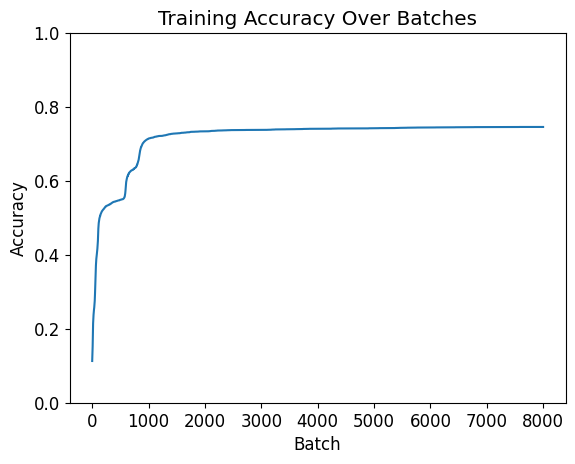

In [156]:
plot_accuracies(accuracies)